In [1]:
import pandas as pd
import numpy as np

In [2]:
def read_data(L):
    """
    :type L: int(system size)
    :rtype train,test: pd.dataframe(with phases labeled)
    """
    train_filename='configuration'+str(L)+'.csv'
    test_filename='test'+str(L)+'.csv'
    columns=['temperature']+['Spin'+str(i) for i in xrange(1,2*L*L+1)]
    train=pd.read_csv('Ising_gauge_data/'+'L'+str(L)+'/'+train_filename,names=columns)
    test=pd.read_csv('Ising_gauge_data/'+'L'+str(L)+'/'+test_filename,names=columns)
    
    # Separate T=0 and T=inf
    Tc=2.
    
    # add phase column (T=0: 1, T=inf: 0)
    train['phase']=[int(T<=Tc) for T in train['temperature']]
    test['phase']=[int(T<=Tc) for T in test['temperature']]
    
    return train , test

In [3]:
L=20
train, test=read_data(L)

In [4]:
train.head()

,temperature,Spin1,Spin2,Spin3,Spin4,Spin5,Spin6,Spin7,Spin8,Spin9,...,Spin792,Spin793,Spin794,Spin795,Spin796,Spin797,Spin798,Spin799,Spin800,phase
0,0.001,-1,1,-1,-1,-1,-1,1,-1,-1,...,1,-1,-1,-1,-1,-1,1,1,1,1
1,0.001,-1,1,1,1,1,-1,-1,-1,-1,...,1,1,1,1,-1,1,-1,1,1,1
2,0.001,1,-1,1,-1,-1,-1,1,-1,1,...,-1,1,1,1,-1,1,1,1,1,1
3,0.001,1,1,1,-1,-1,1,1,1,-1,...,-1,1,1,-1,-1,-1,-1,-1,1,1
4,0.001,1,1,1,1,1,1,-1,-1,-1,...,-1,-1,-1,-1,1,-1,1,1,-1,1


In [5]:
def data_process(train, shuffle=True):
    """
    :type train,test: pd.dataframe(with phases labeled)
    :rtype trX, trY, teX, teY
    """
    # shuffle
    if shuffle:
        train=train.sample(frac=1).reset_index(drop=True)
    
    # separate A, B sublattices
    trainA=train[['Spin'+str(i) for i in xrange(1,L*L+1)]].as_matrix()
    trainB=train[['Spin'+str(i) for i in xrange(L*L+1,2*L*L+1)]].as_matrix()
    trX=np.zeros((trainA.shape[0], L, L, 2))
    trX[:,:,:,0]=np.reshape(trainA,(trainA.shape[0], L, L))
    trX[:,:,:,1]=np.reshape(trainB,(trainB.shape[0], L, L))
    
    trY = train['phase']
    
    return trX, trY

In [6]:
trX, trY=data_process(train)
teX, teY=data_process(test)

**check plaquette**

In [7]:
def plaquette(links):
    plaquette = np.zeros((links.shape[0], L, L))
                
    for i in xrange(L):
        for j in xrange(L):
            plaquette[:, i, j]=links[:, i, j, 0]*links[:, i, j, 1]\
            *links[:, (i+1)%L, j, 1]*links[:, i, (j+1)%L, 0]
                
    return plaquette

In [8]:
plaq=plaquette(trX)
plaq

array([[[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]],

       ..., 
       [[-1., -1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1., -1., ...,  1., -1.,  1.],
        [-1.,  1., -1., ...,  1.,  1., 

In [9]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [10]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(64, (2, 2), input_shape = (L, L, 2), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 64, activation = 'relu'))
# drop out
classifier.add(Dropout(p = 0.1))

classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
adam=Adam(lr=0.0001)
classifier.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

/Users/chenyinglong/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`


In [11]:
classifier.fit(trX,trY,batch_size=100, nb_epoch=25, verbose=0)

/Users/chenyinglong/anaconda/lib/python2.7/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [12]:
try_pred=classifier.predict(trX)
tey_pred=classifier.predict(teX)

In [13]:
np.mean((try_pred>0.5)[:,0]==trY)

1.0

In [14]:
tey_pred.shape

(10000, 1)

In [15]:
np.mean((tey_pred>0.5)[:,0]==teY)

1.0

**predict cross-over temperature on finite temperature data**:

In [16]:
def read_finite(L):
    filename='test_finiteT'+str(L)+'.csv'
    columns=['beta']+['Spin'+str(i) for i in xrange(1,2*L*L+1)]
    data=pd.read_csv('Ising_gauge_data/'+'L'+str(L)+'/'+filename,names=columns)
    
    return data

In [17]:
def data_process_finite(test):
    """
    :type train,test: pd.dataframe(with phases labeled)
    :rtype trX, trY, teX, teY
    """
    # separate A, B sublattices
    testA=test[['Spin'+str(i) for i in xrange(1,L*L+1)]].as_matrix()
    testB=test[['Spin'+str(i) for i in xrange(L*L+1,2*L*L+1)]].as_matrix()
    teX=np.zeros((testA.shape[0], L, L, 2))
    teX[:,:,:,0]=np.reshape(testA,(testA.shape[0], L, L))
    teX[:,:,:,1]=np.reshape(testB,(testB.shape[0], L, L))
    
    return teX

In [18]:
test_finite=read_finite(L)
teX=data_process_finite(test_finite)

In [19]:
y_pred=classifier.predict(teX)

In [20]:
y_pred=(y_pred>0.5)

In [21]:
Betas=np.array(sorted(list(set(test_finite['beta']))))
Pred_avgs=[]
num_T=Betas.shape[0]
num_test=len(test_finite['beta'])
batch=num_test/num_T

for i in xrange(num_T):
    start=batch*i
    end=start+batch
    batch_prediction=y_pred[start:end]
    Pred_avgs.append(np.mean(batch_prediction,axis=0))

Pred_avgs=np.array(Pred_avgs)

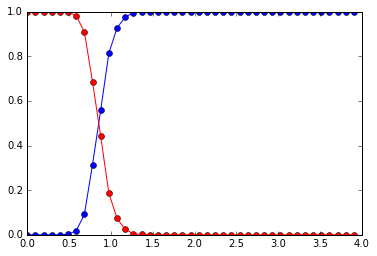

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(Betas, Pred_avgs[:,0], 'bo', Betas, Pred_avgs[:,0], 'b-', \
         Betas, 1-Pred_avgs[:,0], 'ro', Betas, 1-Pred_avgs[:,0], 'r-')

In [23]:
teX.shape

(102500, 20, 20, 2)

In [24]:
batch

2500